# Load data from STAEformer

In [6]:
import os 
import numpy as np 
path = os.path.expanduser('~/staeformer/data/inputs_model')
print(os.listdir(path))
for input in ['x','y']:
    for training_mode in ['train','val','test']:
        for scaled in ['','_scaled']:
            locals()[f'{input}_{training_mode}'] = np.load(f'{path}/{input}_{training_mode}{scaled}.npy')


['x_train.npy', 'y_train.npy', 'x_val.npy', 'y_val.npy', 'x_test.npy', 'y_test.npy', 'x_train_scaled.npy', 'y_train_scaled.npy', 'x_val_scaled.npy', 'y_val_scaled.npy', 'x_test_scaled.npy', 'y_test_scaled.npy']


# Load data from my own framework

In [10]:
path_save = os.path.expanduser('~/prediction-validation/save/data')
inputs_names = []
for training_mode in ['train','valid','test']:
    for input in ['U','Utarget','calendar_dayofweek','calendar_timeofday','PeMS08_occupancy','PeMS08_speed']:
        inputs_names.append(f'{input}_{training_mode}')
        locals()[f'{input}_{training_mode}'] = np.load(f'{path_save}/{input}_{training_mode}.npy')
print(inputs_names)


['U_train', 'Utarget_train', 'calendar_dayofweek_train', 'calendar_timeofday_train', 'PeMS08_occupancy_train', 'PeMS08_speed_train', 'U_valid', 'Utarget_valid', 'calendar_dayofweek_valid', 'calendar_timeofday_valid', 'PeMS08_occupancy_valid', 'PeMS08_speed_valid', 'U_test', 'Utarget_test', 'calendar_dayofweek_test', 'calendar_timeofday_test', 'PeMS08_occupancy_test', 'PeMS08_speed_test']


In [20]:
x_train_perso = np.stack([U_train,PeMS08_occupancy_train,PeMS08_speed_train],axis=-1)
x_train_perso = x_train_perso.transpose(0,2,1,3)
y_train_perso = np.expand_dims(Utarget_train.transpose(0,2,1),-1)

x_train.shape,y_train.shape, x_train_perso.shape,y_train_perso.shape

((10700, 12, 170, 3),
 (10700, 12, 170, 1),
 (10699, 12, 170, 3),
 (10699, 12, 170, 1))

In [40]:
y_train_perso[:,0,0,0]/y_train[1:,0,0,0]

array([-0.02094262, -0.01727605, -0.01625799, ..., -0.02031854,
       -0.02101242, -0.01738597], dtype=float32)

# Ils semblent identique, mais pas avec la même normalisation:

<Axes: >

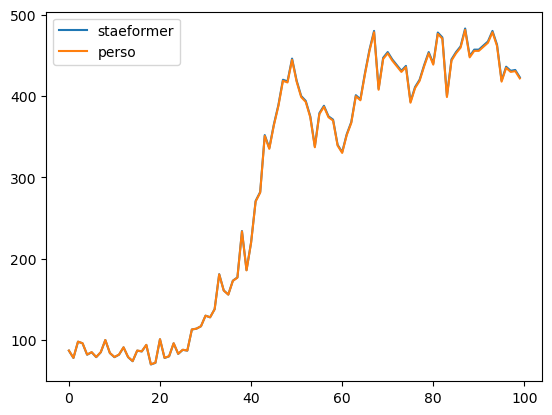

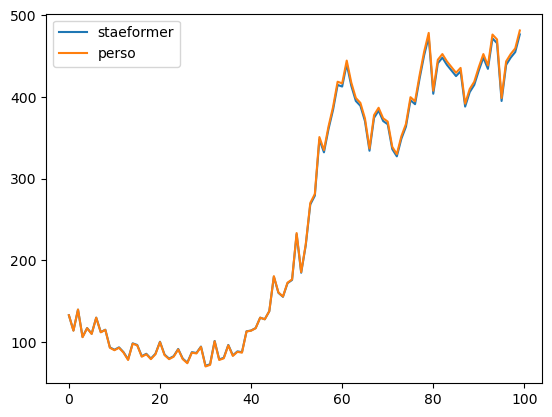

In [88]:
import pandas as pd
pd.DataFrame(dict(staeformer = y_train[:-1,0,0,0], perso = 150.5*y_train_perso[:,0,0,0]+333)).iloc[:100].plot()
pd.DataFrame(dict(staeformer = 143*x_train[:-1,0,0,0]+228, perso = 150.5*x_train_perso[:,0,0,0]+333)).iloc[:100].plot()

In [31]:
print(x_train[:100,0,0,0])
print(x_train_perso[:100,0,0,0])

[-0.6650151  -0.79548675 -0.6169466  -0.85042214 -0.77488595 -0.8229544
 -0.68561584 -0.8092206  -0.7886198  -0.93969226 -0.960293   -0.93969226
 -0.9808938  -1.0426961  -0.9053576  -0.91909146 -1.0152285  -0.99462765
 -1.0358292  -0.99462765 -0.89162374 -1.0014946  -1.0358292  -1.0152285
 -0.9534261  -1.0358292  -1.0701638  -0.9808938  -0.9877607  -0.9328253
 -1.0976316  -1.0838977  -0.8847568  -1.0426961  -1.0289623  -0.91909146
 -1.0083616  -0.97402686 -0.9808938  -0.8023537  -0.79548675 -0.77488595
 -0.68561584 -0.6993497  -0.63068044 -0.3354025  -0.47274107 -0.5070757
 -0.3903379  -0.3628702   0.02854476 -0.30106783 -0.06759225  0.28262115
  0.35815737  0.8388424   0.72897154  0.92811245  1.0929188   1.3057935
  1.2920597   1.4843338   1.2989266   1.168455    1.1272534   0.99678177
  0.7427054   1.0242494   1.0860518   0.99678177  0.96931404  0.75643927
  0.6946369   0.8457093   0.94871324  1.1753219   1.1409873   1.360729
  1.5598699   1.7178093   1.2302574   1.4912007   1.539269

In [ ]:
import os 
import pandas as pd
import json
import geopandas as gpd
from shapely.geometry import Point

# Init
root_repository = os.path.expanduser('~') #prediction_validation/
save_folder = f"{root_repository}/../../data/rrochas/raw_data/Comptages_Velo_Routier/CRITER"


# Load GDF 
json_name = 'pvo_patrimoine_voirie.pvocomptagecriter.json'
sensor_json = json.load(open(f"{save_folder}/{json_name}",'rb'))
sensor_json['values']

gdf_criter = gpd.GeoDataFrame(
    [
        {**feat,
         'geometry': Point(feat['lon'],feat['lat'])}
        for feat in sensor_json['values']
    ],
    crs="EPSG:4326"
)


year = 2019
months = ['Janvier','Fevrier','Mars','Avril','Mai','Juin','Juillet','Aout','Septembre','Octobre','Novembre','Decembre']
sensors_3_4_5_lanes = gdf_criter[gdf_criter.nbvoies > 2]['identifiantptm'].unique().astype(int)

df_all_3_4_5_lanes = pd.DataFrame()
for nb_month in [3,4,5]:
    txt_path = f"{save_folder}/6 min {year}/6mn_{str(nb_month).zfill(2)}_{months[nb_month-1]}_{year}.txt"

    df = pd.read_csv(txt_path, sep=';')
    format = "%d/%m/%Y %H:%M:%S"
    format_without_time = "%d/%m/%Y"
    format_hour = pd.to_datetime(df.HORODATE,format=format,errors = 'coerce')
    format_day = pd.to_datetime(df.HORODATE,format=format_without_time,errors = 'coerce')
    df.HORODATE = format_hour.combine_first(format_day)
    df['day'] = df.HORODATE.dt.day
    df['str_hour_min'] = df.HORODATE.dt.hour.astype(str) + pd.Series([':']*len(df)) + df.HORODATE.dt.minute.astype(str)
    df['hour_min'] = 10*df.HORODATE.dt.hour +  (df.HORODATE.dt.minute)/6
    df_filtered = df[df.ID_POINT_MESURE.isin(sensors_3_4_5_lanes)]
    print(f"On conserve seulement {'{:.2%}'.format(len(df_filtered)/len(df))} de la df initiale.")

    df_all_3_4_5_lanes = pd.concat([df_all_3_4_5_lanes,df_filtered])
print('Couverture Temporelle: ',df_all_3_4_5_lanes.HORODATE.min(),df_all_3_4_5_lanes.HORODATE.max())
display(df_all_3_4_5_lanes.head())

On conserve seulement 8.32% de la df initiale.
On conserve seulement 8.31% de la df initiale.


In [57]:
import json
import geopandas as gpd
from shapely.geometry import Point
json_name = 'pvo_patrimoine_voirie.pvocomptagecriter.json'
sensor_json = json.load(open(f"{save_folder}/{json_name}",'rb'))
sensor_json['values']

gdf_criter = gpd.GeoDataFrame(
    [
        {**feat,
         'geometry': Point(feat['lon'],feat['lat'])}
        for feat in sensor_json['values']
    ],
    crs="EPSG:4326"
)
gdf_criter[gdf_criter.nbvoies > 2].explore(tiles="Cartodb Positron")